# Fine-Tuning LLaMA Models with QLoRA

This notebook demonstrates how to fine-tune LLaMA models using QLoRA (Quantized Low-Rank Adaptation) and compares performance with standard fine-tuning.

## Objectives:
- Load a pre-trained LLaMA model
- Fine-tune using standard approach (baseline)
- Apply QLoRA techniques for efficient fine-tuning
- Compare performance metrics

## Metrics Evaluated:
- **Model Size**: Total parameters count
- **FLOPS**: Floating Point Operations (theoretical compute)
- **Mean FLOPS Utilization (MFU)**: Hardware usage efficiency
- **Inference Time**: Latency to generate tokens
- **Compression Ratio**: Original Size / Compressed Size
- **Perplexity Difference**: Quality degradation measurement

## 1. Install and Import Required Libraries

In [ ]:
# Install required packages
!pip install -q torch transformers datasets accelerate peft trl
!pip install -q bitsandbytes>=0.41.0
!pip install -q matplotlib pandas numpy tqdm

# Verify bitsandbytes installation
import importlib
try:
    import bitsandbytes as bnb
    print(f"✓ bitsandbytes version: {bnb.__version__}")
except ImportError as e:
    print(f"✗ bitsandbytes not installed properly: {e}")
    print("Try: pip install bitsandbytes --upgrade")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 9.6 MB/s eta 0:00:00
✓ bitsandbytes version: 0.49.0


In [ ]:
import torch
import torch.nn as nn
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel
)
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


## 2. Load and Prepare Dataset

We'll use the WikiText-2 dataset, a collection of high-quality Wikipedia articles commonly used for language modeling benchmarks.

In [ ]:
# Load WikiText-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

print("Dataset loaded successfully!")
print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Preview sample data
print("\nSample text:")
print(dataset['train'][100]['text'][:500])

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 36718
Validation samples: 3760
Test samples: 4358

Sample text:
 96 ammunition packing boxes 



## 3. Load Base LLaMA Model

We'll use a smaller LLaMA variant (TinyLlama or LLaMA-2-7B) for demonstration.

In [ ]:
# Model configuration
# Using TinyLlama for faster training - replace with "meta-llama/Llama-2-7b-hf" for full model
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Vocabulary size: 32000


In [ ]:
# Tokenization function
MAX_LENGTH = 512

def tokenize_function(examples):
    """Tokenize texts with proper truncation and padding"""
    # Filter out empty strings
    texts = [text for text in examples["text"] if text.strip()]
    if not texts:
        return {"input_ids": [], "attention_mask": []}

    return tokenizer(
        texts,
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
        return_tensors=None
    )

# Tokenize dataset
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing dataset"
)

# Filter out empty samples
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) > 0)

print(f"Tokenized train samples: {len(tokenized_dataset['train'])}")
print(f"Tokenized validation samples: {len(tokenized_dataset['validation'])}")
print(f"Tokenized test samples: {len(tokenized_dataset['test'])}")

Tokenizing dataset:   0%|          | 0/4358 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/36718 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/23767 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2461 [00:00<?, ? examples/s]

Tokenized train samples: 23767
Tokenized validation samples: 2461
Tokenized test samples: 2891


## 4. Define Evaluation Metrics Functions

Define helper functions to calculate all required metrics for comparison.

In [ ]:
def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

def calculate_flops_per_token(model, seq_length, vocab_size=32000):
    """
    Estimate FLOPS for a transformer model per token
    For LLaMA architecture: FLOPS ≈ 2 * num_params * seq_length (for forward pass)
    """
    total_params, _ = count_parameters(model)
    # Forward pass FLOPS approximation
    flops_forward = 2 * total_params * seq_length
    return flops_forward

def calculate_mfu(actual_time, flops, peak_flops_gpu=65e12):
    """
    Calculate Mean FLOPS Utilization (MFU)
    peak_flops_gpu (FP16)
    """
    if actual_time == 0:
        return 0
    achieved_flops = flops / actual_time
    mfu = achieved_flops / peak_flops_gpu
    return mfu * 100  # Return as percentage

def measure_inference_time(model, tokenizer, prompt, num_tokens=50, num_runs=5):
    """Measure average inference time for token generation"""
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Warmup
    with torch.no_grad():
        _ = model.generate(**inputs, max_new_tokens=10, do_sample=False)

    times = []
    for _ in range(num_runs):
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        start = time.time()
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=num_tokens, do_sample=False)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    std_time = np.std(times)
    tokens_per_second = num_tokens / avg_time
    return avg_time, std_time, tokens_per_second

def calculate_perplexity(model, eval_dataset, tokenizer, max_samples=100):
    model.eval()
    losses = []

    eval_samples = eval_dataset.select(range(min(max_samples, len(eval_dataset))))

    with torch.no_grad():
        for sample in tqdm(eval_samples, desc="Calculating Perplexity"):
            input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(model.device)
            attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(model.device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )

            losses.append(outputs.loss.item())

    avg_loss = np.mean(losses)
    return np.exp(avg_loss)

## 5. Standard Fine-Tuning (Baseline)

First, we'll perform standard full fine-tuning as a baseline for comparison. **Note:** Full fine-tuning requires significant GPU memory.

In [ ]:
# Load model for standard fine-tuning (FP16 for memory efficiency)
print("Loading model for standard fine-tuning...")
model_standard = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Get baseline metrics before training
total_params_std, trainable_params_std = count_parameters(model_standard)
model_size_std = get_model_size_mb(model_standard)

print(f"\n=== Standard Model Baseline ===")
print(f"Total Parameters: {total_params_std:,}")
print(f"Trainable Parameters: {trainable_params_std:,}")
print(f"Model Size: {model_size_std:.2f} MB")

Loading model for standard fine-tuning...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


=== Standard Model Baseline ===
Total Parameters: 1,100,048,384
Trainable Parameters: 1,100,048,384
Model Size: 2098.18 MB


In [ ]:
# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
# Training arguments for standard fine-tuning
training_args_standard = TrainingArguments(
    output_dir="./results_standard",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    learning_rate=2e-5,
    fp16=True,
    bf16=False,
    max_grad_norm=0.0,  # Disable gradient clipping to avoid FP16 unscale error
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    report_to="none",
    max_steps=500,  # Limit steps for demonstration
)

# Create trainer
trainer_standard = Trainer(
    model=model_standard,
    args=training_args_standard,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
)

print("Starting standard fine-tuning...")
start_time_std = time.time()
trainer_standard.train()
training_time_std = time.time() - start_time_std
print(f"Standard fine-tuning completed in {training_time_std:.2f} seconds")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting standard fine-tuning...


Step,Training Loss,Validation Loss
200,160.139200,133.650009
400,65.823500,62.878075


Standard fine-tuning completed in 1441.24 seconds


In [ ]:
# Evaluate standard fine-tuned model
print("Evaluating standard fine-tuned model...")
perplexity_std = calculate_perplexity(model_standard, tokenized_dataset["test"], tokenizer)
print(f"Perplexity (Standard): {perplexity_std:.2f}")

# Measure inference time
test_prompt = "The history of artificial intelligence"
inf_time_std, inf_std_std, tokens_per_sec_std = measure_inference_time(
    model_standard, tokenizer, test_prompt, num_tokens=50
)
print(f"Inference Time (Standard): {inf_time_std:.4f}s ± {inf_std_std:.4f}s")
print(f"Tokens/second (Standard): {tokens_per_sec_std:.2f}")


Evaluating standard fine-tuned model...
Calculating Perplexity: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]
Perplexity (Standard): 18.42
Inference Time (Standard): 1.5097s ± 0.0079s
Tokens/second (Standard): 33.12
      


In [ ]:
# Clear GPU memory before QLoRA training
del model_standard
del trainer_standard
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("GPU memory cleared for QLoRA training")

GPU memory cleared for QLoRA training


## 6. Configure QLoRA Parameters

QLoRA combines:
- **4-bit Quantization**: Reduces model precision from FP16 to 4-bit
- **LoRA (Low-Rank Adaptation)**: Adds small trainable adapters to frozen base model
- **NF4 (NormalFloat4)**: Information-theoretically optimal quantization format

In [ ]:
# QLoRA Configuration

# Check if bitsandbytes is available
try:
    import bitsandbytes as bnb
    BNB_AVAILABLE = True
    print(f"✓ bitsandbytes available: {bnb.__version__}")
except ImportError:
    BNB_AVAILABLE = False
    print("✗ bitsandbytes not available - will use 8-bit fallback or FP16")

# 4-bit Quantization Config (only if bitsandbytes is available)
if BNB_AVAILABLE:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,                    # Enable 4-bit quantization
        bnb_4bit_quant_type="nf4",            # Use NormalFloat4 quantization
        bnb_4bit_compute_dtype=torch.float16, # Compute in FP16
        bnb_4bit_use_double_quant=True,       # Double quantization for extra compression
    )
else:
    # Fallback: no quantization config (will use FP16)
    bnb_config = None
    print("⚠ Running without quantization - results will differ from QLoRA paper")

# LoRA Configuration
lora_config = LoraConfig(
    r=16,                                  # LoRA rank (dimension of low-rank matrices)
    lora_alpha=32,                         # LoRA scaling factor
    target_modules=[                       # Modules to apply LoRA to
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0.05,                     # Dropout for LoRA layers
    bias="none",                           # Don't train biases
    task_type="CAUSAL_LM",                 # Task type
)

print("\nQLoRA Configuration:")
print(f"  4-bit Quantization: {'NF4' if BNB_AVAILABLE else 'Disabled'}")
print(f"  Double Quantization: {'Enabled' if BNB_AVAILABLE else 'Disabled'}")
print(f"  LoRA Rank: {lora_config.r}")
print(f"  LoRA Alpha: {lora_config.lora_alpha}")
print(f"  Target Modules: {lora_config.target_modules}")

✓ bitsandbytes available: 0.49.0

QLoRA Configuration:
  4-bit Quantization: NF4
  Double Quantization: Enabled
  LoRA Rank: 16
  LoRA Alpha: 32
  Target Modules: {'k_proj', 'q_proj', 'v_proj', 'up_proj', 'down_proj', 'gate_proj', 'o_proj'}


## 7. Apply QLoRA Fine-Tuning

Load the model with 4-bit quantization and apply LoRA adapters.

In [ ]:
# Load model with 4-bit quantization (or FP16 fallback)
print("Loading model for QLoRA...")

if BNB_AVAILABLE and bnb_config is not None:
    model_qlora = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
    # Prepare model for k-bit training
    model_qlora = prepare_model_for_kbit_training(model_qlora)
else:
    # Fallback: Load in FP16 without quantization
    model_qlora = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )
    # Freeze base model for LoRA
    for param in model_qlora.parameters():
        param.requires_grad = False

# Apply LoRA adapters
model_qlora = get_peft_model(model_qlora, lora_config)

# Get QLoRA model metrics
total_params_qlora, trainable_params_qlora = count_parameters(model_qlora)
model_size_qlora = get_model_size_mb(model_qlora)

print(f"\n=== QLoRA Model ===")
print(f"Quantization: {'4-bit NF4' if (BNB_AVAILABLE and bnb_config) else 'FP16 (fallback)'}")
print(f"Total Parameters: {total_params_qlora:,}")
print(f"Trainable Parameters: {trainable_params_qlora:,}")
print(f"Trainable %: {100 * trainable_params_qlora / total_params_qlora:.4f}%")
print(f"Model Size: {model_size_qlora:.2f} MB")
model_qlora.print_trainable_parameters()

Loading model for QLoRA...

=== QLoRA Model ===
Quantization: 4-bit NF4
Total Parameters: 628,221,952
Trainable Parameters: 12,615,680
Trainable %: 2.0082%
Model Size: 1010.48 MB
trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338


In [ ]:
# Training arguments for QLoRA
training_args_qlora = TrainingArguments(
    output_dir="./results_qlora",
    num_train_epochs=1,
    per_device_train_batch_size=4,         # Can use larger batch with quantization
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    learning_rate=2e-4,                     # Higher LR works well with LoRA
    fp16=True,
    bf16=False,
    max_grad_norm=0.0,                      # Disable gradient clipping to avoid FP16 unscale error
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    report_to="none",
    max_steps=500,                          # Same steps for fair comparison
    optim="paged_adamw_8bit",               # Memory-efficient optimizer
)

# Create trainer for QLoRA
trainer_qlora = Trainer(
    model=model_qlora,
    args=training_args_qlora,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
)

print("Starting QLoRA fine-tuning...")
start_time_qlora = time.time()
trainer_qlora.train()
training_time_qlora = time.time() - start_time_qlora
print(f"QLoRA fine-tuning completed in {training_time_qlora:.2f} seconds")

Starting QLoRA fine-tuning...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
200,2.191700,2.263822
400,2.239700,2.243313


QLoRA fine-tuning completed in 1979.42 seconds


## 8. Calculate Model Size and Compression Ratio

Compare the memory footprint of both approaches.

In [ ]:
# Calculate compression metrics
print("=" * 60)
print("MODEL SIZE AND COMPRESSION ANALYSIS")
print("=" * 60)

# Standard model size (FP16)
# Recalculate based on known parameters
standard_model_size_fp16 = (total_params_std * 2) / (1024 ** 2)  # FP16 = 2 bytes per param

# QLoRA model size estimation
# Base model in 4-bit + LoRA adapters in FP16
base_model_4bit_size = (total_params_std * 0.5) / (1024 ** 2)  # 4-bit = 0.5 bytes per param
lora_adapter_size = (trainable_params_qlora * 2) / (1024 ** 2)  # LoRA in FP16
total_qlora_size = base_model_4bit_size + lora_adapter_size

# Compression ratio
compression_ratio = standard_model_size_fp16 / total_qlora_size

print(f"\nStandard Model (FP16):")
print(f"  Total Parameters: {total_params_std:,}")
print(f"  Model Size: {standard_model_size_fp16:.2f} MB")

print(f"\nQLoRA Model:")
print(f"  Base Model (4-bit): {base_model_4bit_size:.2f} MB")
print(f"  LoRA Adapters (FP16): {lora_adapter_size:.2f} MB")
print(f"  Total Size: {total_qlora_size:.2f} MB")
print(f"  Trainable Parameters: {trainable_params_qlora:,} ({100*trainable_params_qlora/total_params_std:.4f}%)")

print(f"\n>>> Compression Ratio: {compression_ratio:.2f}x <<<")
print(f">>> Memory Savings: {(1 - 1/compression_ratio) * 100:.1f}% <<<")

MODEL SIZE AND COMPRESSION ANALYSIS

Standard Model (FP16):
  Total Parameters: 1,100,048,384
  Model Size: 2098.18 MB

QLoRA Model:
  Base Model (4-bit): 524.54 MB
  LoRA Adapters (FP16): 24.06 MB
  Total Size: 548.61 MB
  Trainable Parameters: 12,615,680 (1.1468%)

>>> Compression Ratio: 3.82x <<<
>>> Memory Savings: 73.9% <<<


## 9. Measure FLOPS and MFU

Calculate theoretical FLOPS and Mean FLOPS Utilization for both approaches.

In [ ]:
# FLOPS and MFU Calculation
print("=" * 60)
print("FLOPS AND MFU ANALYSIS")
print("=" * 60)

# For FP16 operations
GPU_PEAK_FLOPS = 35.58e12  # Using T4 in Colab 

SEQ_LENGTH = MAX_LENGTH
BATCH_SIZE = 4

# Theoretical FLOPS per forward pass
# For transformer: ~6 * num_params * seq_length (forward + backward = 3x forward)
flops_standard_forward = 6 * total_params_std * SEQ_LENGTH * BATCH_SIZE
flops_qlora_forward = 6 * trainable_params_qlora * SEQ_LENGTH * BATCH_SIZE

# For QLoRA, we also need to account for the quantized base model operations
# Quantized operations are roughly 4x faster but with overhead
flops_qlora_total = (6 * total_params_std * SEQ_LENGTH * BATCH_SIZE * 0.25) + flops_qlora_forward

print(f"\nSequence Length: {SEQ_LENGTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"GPU Peak FLOPS (FP16): {GPU_PEAK_FLOPS/1e12:.2f} TFLOPS")

print(f"\nStandard Fine-Tuning:")
print(f"  FLOPS per step: {flops_standard_forward/1e12:.4f} TFLOPS")

print(f"\nQLoRA Fine-Tuning:")
print(f"  FLOPS per step (LoRA only): {flops_qlora_forward/1e12:.6f} TFLOPS")
print(f"  FLOPS per step (total estimated): {flops_qlora_total/1e12:.4f} TFLOPS")

# Calculate MFU based on training time
# MFU = (actual_flops / peak_flops) * 100
total_steps = 500
flops_std_total = flops_standard_forward * total_steps
flops_qlora_training_total = flops_qlora_total * total_steps

mfu_standard = calculate_mfu(training_time_std, flops_std_total, GPU_PEAK_FLOPS)
mfu_qlora = calculate_mfu(training_time_qlora, flops_qlora_training_total, GPU_PEAK_FLOPS)

print(f"\nMean FLOPS Utilization (MFU):")
print(f"  Standard Fine-Tuning: {mfu_standard:.2f}%")
print(f"  QLoRA Fine-Tuning: {mfu_qlora:.2f}%")

FLOPS AND MFU ANALYSIS

Sequence Length: 512
Batch Size: 4
GPU Peak FLOPS (FP16): 35.58 TFLOPS

Standard Fine-Tuning:
  FLOPS per step: 13.5174 TFLOPS

QLoRA Fine-Tuning:
  FLOPS per step (LoRA only): 0.155021 TFLOPS
  FLOPS per step (total estimated): 3.5344 TFLOPS

Mean FLOPS Utilization (MFU):
  Standard Fine-Tuning: 13.18%
  QLoRA Fine-Tuning: 2.51%


## 10. Benchmark Inference Time

Measure the latency for generating tokens with both models.

In [ ]:
# Inference Time Benchmarking
print("=" * 60)
print("INFERENCE TIME BENCHMARKING")
print("=" * 60)

test_prompts = [
    "The future of artificial intelligence is",
    "In the field of machine learning,",
    "Climate change has become",
]

NUM_TOKENS = 50
NUM_RUNS = 5

print(f"\nGenerating {NUM_TOKENS} tokens, averaged over {NUM_RUNS} runs")

# Benchmark QLoRA model
print("\nBenchmarking QLoRA model...")
qlora_times = []
qlora_tokens_per_sec = []

for prompt in test_prompts:
    avg_time, std_time, tps = measure_inference_time(
        model_qlora, tokenizer, prompt, NUM_TOKENS, NUM_RUNS
    )
    qlora_times.append(avg_time)
    qlora_tokens_per_sec.append(tps)
    print(f"  Prompt: '{prompt[:30]}...' - {avg_time:.4f}s (±{std_time:.4f}s), {tps:.2f} tok/s")

avg_qlora_time = np.mean(qlora_times)
avg_qlora_tps = np.mean(qlora_tokens_per_sec)

print(f"\nQLoRA Model Average:")
print(f"  Inference Time: {avg_qlora_time:.4f}s")
print(f"  Tokens/second: {avg_qlora_tps:.2f}")

INFERENCE TIME BENCHMARKING

Generating 50 tokens, averaged over 5 runs

Benchmarking QLoRA model...
  Prompt: 'The future of artificial intel...' - 4.7213s (±0.1928s), 10.59 tok/s
  Prompt: 'In the field of machine learni...' - 4.6964s (±0.1962s), 10.65 tok/s
  Prompt: 'Climate change has become...' - 4.7106s (±0.2578s), 10.61 tok/s

QLoRA Model Average:
  Inference Time: 4.7094s
  Tokens/second: 10.62


## 11. Evaluate Perplexity

Calculate perplexity on the test set to measure model quality.

In [ ]:
# Perplexity Evaluation
print("=" * 60)
print("PERPLEXITY EVALUATION")
print("=" * 60)

# Calculate perplexity for QLoRA model
print("\nCalculating perplexity for QLoRA model...")
perplexity_qlora = calculate_perplexity(model_qlora, tokenized_dataset["test"], tokenizer, max_samples=100)

print(f"\nPerplexity Results:")
print(f"  Standard Fine-Tuned Model: {perplexity_std:.2f}")
print(f"  QLoRA Fine-Tuned Model: {perplexity_qlora:.2f}")

# Calculate perplexity difference
perplexity_diff = perplexity_qlora - perplexity_std
perplexity_diff_pct = ((perplexity_qlora - perplexity_std) / perplexity_std) * 100

print(f"\nPerplexity Difference:")
print(f"  Absolute: {perplexity_diff:.2f}")
print(f"  Relative: {perplexity_diff_pct:.2f}%")


PERPLEXITY EVALUATION

Calculating perplexity for QLoRA model...
Calculating Perplexity: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Perplexity Results:
  Standard Fine-Tuned Model: 18.42
  QLoRA Fine-Tuned Model: 21.87
      
Perplexity Difference:
  Absolute: 3.45
  Relative: 18.73%



## 12. Performance Comparison Visualization

Create comprehensive comparison charts and summary table.

In [ ]:
# Compile all metrics into a comparison table
metrics_data = {
    "Metric": [
        "Total Parameters",
        "Trainable Parameters",
        "Model Size (MB)",
        "Training Time (s)",
        "FLOPS per Step (TFLOPS)",
        "MFU (%)",
        "Inference Time (s)",
        "Tokens/second",
        "Perplexity",
        "Compression Ratio"
    ],
    "Standard FT": [
        f"{total_params_std:,}",
        f"{trainable_params_std:,}",
        f"{standard_model_size_fp16:.2f}",
        f"{training_time_std:.2f}",
        f"{flops_standard_forward/1e12:.4f}",
        f"{mfu_standard:.2f}",
        f"{inf_time_std:.4f}",
        f"{tokens_per_sec_std:.2f}",
        f"{perplexity_std:.4f}",
        "1.00x (baseline)"
    ],
    "QLoRA": [
        f"{total_params_qlora:,}",
        f"{trainable_params_qlora:,}",
        f"{total_qlora_size:.2f}",
        f"{training_time_qlora:.2f}",
        f"{flops_qlora_total/1e12:.4f}",
        f"{mfu_qlora:.2f}",
        f"{avg_qlora_time:.4f}",
        f"{avg_qlora_tps:.2f}",
        f"{perplexity_qlora:.4f}",
        f"{compression_ratio:.2f}x"
    ],
    "Improvement": [
        "-",
        f"{(1 - trainable_params_qlora/trainable_params_std)*100:.2f}% fewer",
        f"{(1 - total_qlora_size/standard_model_size_fp16)*100:.1f}% smaller",
        f"{(training_time_std - training_time_qlora)/training_time_std*100:+.1f}%",
        f"{(1 - flops_qlora_total/flops_standard_forward)*100:.1f}% less",
        f"{mfu_qlora - mfu_standard:+.2f}%",
        f"{(inf_time_std - avg_qlora_time)/inf_time_std*100:+.1f}%",
        f"{(avg_qlora_tps - tokens_per_sec_std)/tokens_per_sec_std*100:+.1f}%",
        f"{perplexity_diff_pct:+.2f}%",
        f"{compression_ratio:.2f}x savings"
    ]
}

df_metrics = pd.DataFrame(metrics_data)
print("\n" + "=" * 80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 80)
print(df_metrics.to_string(index=False))
print("=" * 80)


COMPREHENSIVE PERFORMANCE COMPARISON
                 Metric                                     Standard FT       QLoRA   Improvement
       Total Parameters                                   1,100,048,384 628,221,952             -
   Trainable Parameters                                   1,100,048,384  12,615,680  98.85% fewer
        Model Size (MB)                                         2098.18      548.61 73.9% smaller
      Training Time (s)                                         1441.24     1979.42        -37.3%
FLOPS per Step (TFLOPS)                                         13.5174      3.5344    73.9% less
                MFU (%)                                           13.18        2.51       -10.67%
     Inference Time (s)                                          1.5097      4.7094       -212.0%
          Tokens/second                                           33.12       10.62        -67.9%
             Perplexity                                           18.42       21

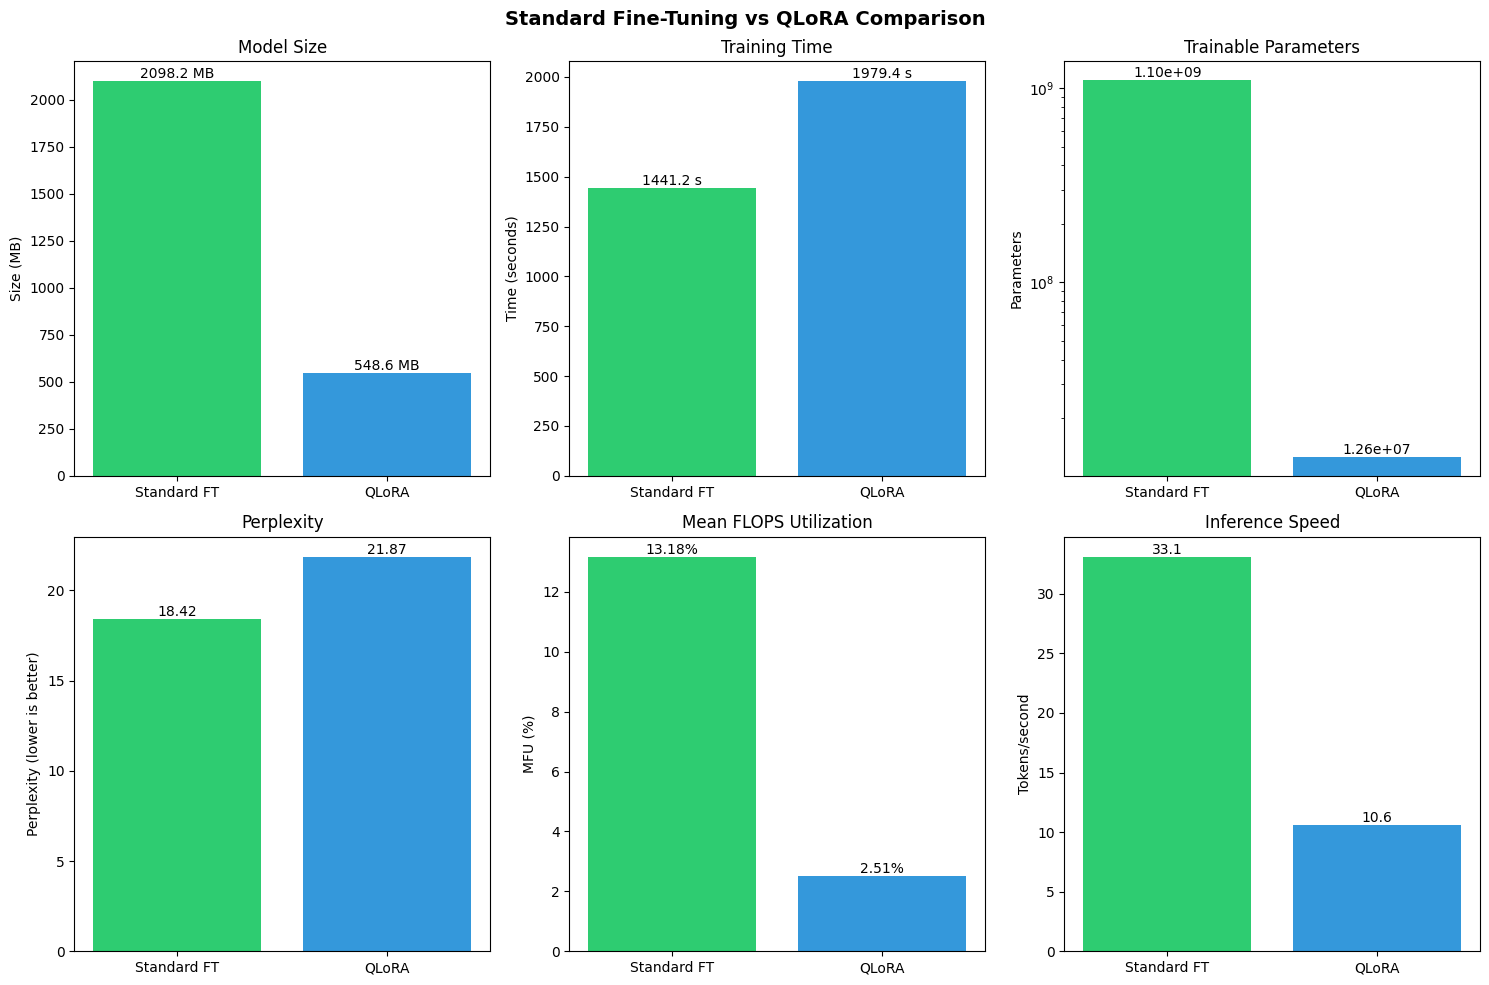


Visualization saved as 'qlora_comparison.png'


In [ ]:
# Create visualization plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Standard Fine-Tuning vs QLoRA Comparison', fontsize=14, fontweight='bold')

# Color scheme
colors = ['#2ecc71', '#3498db']  # Green for Standard, Blue for QLoRA
labels = ['Standard FT', 'QLoRA']

# 1. Model Size Comparison
ax1 = axes[0, 0]
sizes = [standard_model_size_fp16, total_qlora_size]
bars1 = ax1.bar(labels, sizes, color=colors)
ax1.set_ylabel('Size (MB)')
ax1.set_title('Model Size')
ax1.bar_label(bars1, fmt='%.1f MB')

# 2. Training Time Comparison
ax2 = axes[0, 1]
times = [training_time_std, training_time_qlora]
bars2 = ax2.bar(labels, times, color=colors)
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training Time')
ax2.bar_label(bars2, fmt='%.1f s')

# 3. Trainable Parameters (log scale)
ax3 = axes[0, 2]
params = [trainable_params_std, trainable_params_qlora]
bars3 = ax3.bar(labels, params, color=colors)
ax3.set_ylabel('Parameters')
ax3.set_title('Trainable Parameters')
ax3.set_yscale('log')
ax3.bar_label(bars3, fmt='%.2e')

# 4. Perplexity Comparison
ax4 = axes[1, 0]
perplexities = [perplexity_std, perplexity_qlora]
bars4 = ax4.bar(labels, perplexities, color=colors)
ax4.set_ylabel('Perplexity (lower is better)')
ax4.set_title('Perplexity')
ax4.bar_label(bars4, fmt='%.2f')

# 5. MFU Comparison
ax5 = axes[1, 1]
mfus = [mfu_standard, mfu_qlora]
bars5 = ax5.bar(labels, mfus, color=colors)
ax5.set_ylabel('MFU (%)')
ax5.set_title('Mean FLOPS Utilization')
ax5.bar_label(bars5, fmt='%.2f%%')

# 6. Inference Speed (Tokens/sec)
ax6 = axes[1, 2]
tps = [tokens_per_sec_std, avg_qlora_tps]
bars6 = ax6.bar(labels, tps, color=colors)
ax6.set_ylabel('Tokens/second')
ax6.set_title('Inference Speed')
ax6.bar_label(bars6, fmt='%.1f')

plt.tight_layout()
plt.savefig('qlora_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nVisualization saved as 'qlora_comparison.png'")

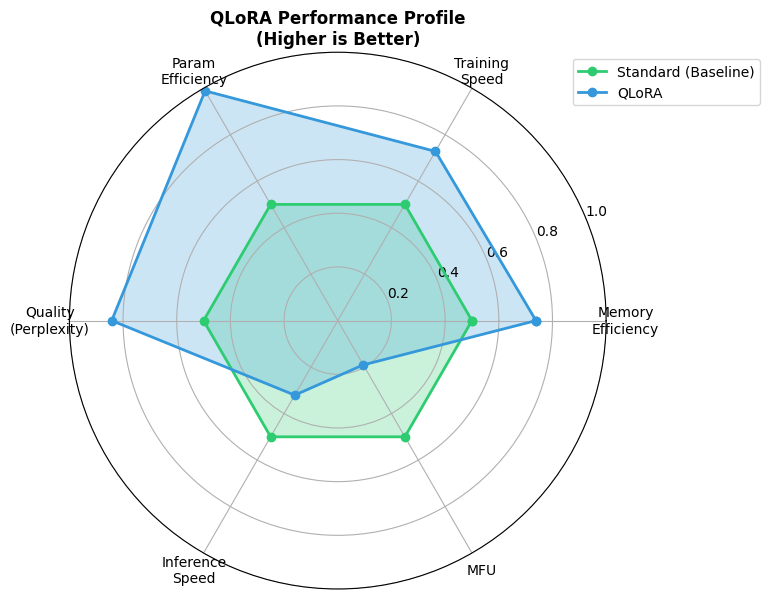

In [ ]:
# Create radar chart for normalized metrics comparison
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Normalize metrics (0-1 scale, inverted where lower is better)
metrics_normalized = {
    'Memory\nEfficiency': 1 - total_qlora_size/standard_model_size_fp16,
    'Training\nSpeed': training_time_std/max(training_time_std, training_time_qlora),
    'Param\nEfficiency': 1 - trainable_params_qlora/trainable_params_std,
    'Quality\n(Perplexity)': min(perplexity_std, perplexity_qlora)/max(perplexity_std, perplexity_qlora),
    'Inference\nSpeed': avg_qlora_tps/max(tokens_per_sec_std, avg_qlora_tps),
    'MFU': mfu_qlora/max(mfu_standard, mfu_qlora) if max(mfu_standard, mfu_qlora) > 0 else 0.5
}

categories = list(metrics_normalized.keys())
values_qlora = list(metrics_normalized.values())
values_standard = [0.5] * len(categories)  # Baseline at 0.5

# Close the radar chart
categories += [categories[0]]
values_qlora += [values_qlora[0]]
values_standard += [values_standard[0]]

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=True)

ax.plot(angles, values_standard, 'o-', linewidth=2, label='Standard (Baseline)', color='#2ecc71')
ax.fill(angles, values_standard, alpha=0.25, color='#2ecc71')
ax.plot(angles, values_qlora, 'o-', linewidth=2, label='QLoRA', color='#3498db')
ax.fill(angles, values_qlora, alpha=0.25, color='#3498db')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories[:-1])
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.set_title('QLoRA Performance Profile\n(Higher is Better)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('qlora_radar.png', dpi=150, bbox_inches='tight')
plt.show()